<a href="https://colab.research.google.com/github/nithin-seenivasan/twitter-analysis/blob/main/FinalProject_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialize Environment**

In [ ]:
!git clone https://github.com/nithin-seenivasan/twitter-analysis

import os
os.chdir("twitter-analysis")

Cloning into 'twitter-analysis'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.


Add the config.py file here, if the API key is required. It's not on Github, since I don't want to expose API key there. 

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 58 kB 3.4 MB/s 
     |████████████████████████████████| 4.0 MB 9.5 MB/s 
     |████████████████████████████████| 88 kB 7.7 MB/s 
     |████████████████████████████████| 1.6 MB 46.0 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.8 MB 54.6 MB/s 
     |████████████████████████████████| 77 kB 8.6 MB/s 
     |████████████████████████████████| 895 kB 65.0 MB/s 
     |████████████████████████████████| 596 kB 70.8 MB/s 
     |████████████████████████████████| 6.6 MB 58.9 MB/s 
     |████████████████████████████████| 1.1 MB 60.1 MB/s 
     |████████████████████████████████| 162 kB 70.9 MB/s 
     |████████████████████████████████| 144 kB 67.5 MB/s 
     |████████████████████████████████| 181 kB 71.0 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
  Created wheel

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import umap
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import sklearn.cluster as cluster
from sklearn import metrics
from scipy import stats

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import scripts.TextAnalysis as ta
from scripts.api import *




import scripts.TextAnalysis as ta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import codecs  #this let's us display tweets properly (emojis, etc.)

pd.set_option("display.max_colwidth", None)


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


#Basic Data Manipulation

##### Load Tweets 

In [ ]:
fname_db = "data/300k_ghostofkiev_acad_22feb_09mar"  #database filenmae (without .db extension)

df = DB.fetch(table_name='keyword_tweets', path=fname_db)

In [ ]:
df.head(2)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities
0,2022-03-08T23:58:47.000Z,None,@vpkivimaki The new ghost of Kiev.,en,0,0,0,0,1501346723628732418,1415540067452473346,1501342968313176064,22245277,nan,"{'mentions': [{'start': 0, 'end': 11, 'username': 'vpkivimaki', 'id': '22245277'}], 'annotations': [{'start': 29, 'end': 32, 'probability': 0.7363, 'type': 'Place', 'normalized_text': 'Kiev'}]}"
1,2022-03-08T23:52:21.000Z,None,Story behind Ghost of Kiev 🤦‍♂️😂😂 https://t.co/opzWGFUqvd,en,1,0,5,0,1501345107722788878,1493051240850284549,1501345107722788878,nan,nan,"{'annotations': [{'start': 22, 'end': 25, 'probability': 0.2601, 'type': 'Place', 'normalized_text': 'Kiev'}], 'urls': [{'start': 34, 'end': 57, 'url': 'https://t.co/opzWGFUqvd', 'expanded_url': 'https://twitter.com/Marckovvvvv2/status/1501345107722788878/video/1', 'display_url': 'pic.twitter.com/opzWGFUqvd'}]}"


##### Add Created at Datetime column (to sort by)

In [ ]:
df_keyword = DB.fetch(table_name='keyword_tweets', path=fname_db)
print(f"{len(df_keyword)} keyword tweets")

format = "%Y-%m-%d %H:%M:%S"
df_keyword ['created_at_datetime'] = pd.to_datetime(df_keyword ['created_at'],format=format).dt.tz_localize(None)
df_keyword .sort_values(by = 'created_at_datetime', inplace = True, ascending = True)
df_keyword ['tweet_indicator'] = np.ones(len(df_keyword ))
df_keyword ['rate_1D'] = df_keyword .rolling('1D',on = 'created_at_datetime').sum()['tweet_indicator']
df_keyword ['rate_7D'] = df_keyword .rolling('7D',on = 'created_at_datetime').sum()['tweet_indicator']/7

17571 keyword tweets


#####Time Series Plot (rate of new tweets)

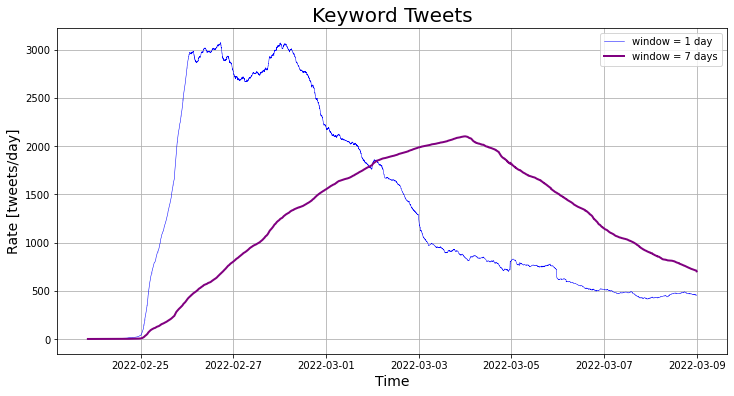

In [ ]:
fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df_keyword , x = 'created_at_datetime',y = 'rate_1D',label = 'window = 1 day',linewidth = .5,color = 'blue')
sns.lineplot(data = df_keyword , x = 'created_at_datetime',y = 'rate_7D',label = 'window = 7 days', linewidth = 2,color = 'purple')

plt.grid()
plt.xlabel("Time", fontsize = 14)

plt.ylabel("Rate [tweets/day]", fontsize = 14)
#plt.xlim(datetime.date(2020, 10, 1),datetime.date(2021,1,1))
#plt.ylim([0,30])
plt.title(f"Keyword Tweets",fontsize = 20)

plt.legend()
plt.show()

#####Sort by Date - what were the first 10 tweets?

In [ ]:
df_keyword[['created_at_datetime','text', 'like_count']].sort_values(by = ['created_at_datetime'], ascending = True).head(n=25)

,created_at_datetime,text,like_count
15835,2022-02-23 20:38:41,"@varbmos @peterdaou Oh my God, this is so Russiagate all over again. One part of the DC ghost story kind of checks out and then you're insane to remember we were promised faked gas attacks and tanks rolling into Kiev.",0
15834,2022-02-24 03:20:16,"Live view from Kyiv, Ukraine.\n\nGhost town.\n\nPrayers for all of Ukraine.\n\nSource: https://t.co/66v0XT1QeW https://t.co/VV6MqUTsjN",3
15833,2022-02-24 07:51:18,"Should I call out of work tomorrow???\n""Sorry, kids. Couldn't come to class last time bc Russia's attacking Kiev half a world away and I'm very antsy about it for reasons that are beyond your understanding rn. But anyways, let's keep writing our Ghost Chicken Nuggets adventure.""",6
15832,2022-02-24 10:15:40,"@daisyelfling This will be a fait acompli over in a few days, all land east of the Dniper will be occupied and Kiev a ghost town on the border",0
15831,2022-02-24 12:15:40,Ghost of kiev https://t.co/DAMmmYxFxB,2
15830,2022-02-24 13:04:48,"@JobeerBa PARAPHRASING: THE EMPTY BRAVADO OF UKRAINE , AND BEHIND THEM is the cowardly SHOE BIDEN, &amp; its western flank with an EMPTY MURMUR, IT IS NOW CLEAR WITH THIS SCENE of THE CAPITAL KIEV #كييف HAS BECOME A GHOST TOWN PREPARING TO RECEIVE PUTIN'S SOLDIERS",1
15829,2022-02-24 13:36:26,Television pictures of ghost town Kiev blaring air raid sirens is absolutely frightening. It's not a false alarm !,1
15828,2022-02-24 16:01:38,"@soluTium1 @GobHenMLDL @SexymhieQ @AJAYRIAH66 @UnitedPatriot22 @WongLi2515 @EyeEres @FhqJackie @ligaya2021 @AltNiSam1 @MissyLizah78 @ACCTV4 @spartacusfilip @Grumpy_YO @raincyrainy @GrowlHarhar @gwapoarawaraw @LoVe_MeOw_24 @itsmeLJHeart @LheysanpI @maine_worldwide @TalaZaldivar @ABCancaloo @DolorNolet @MDSOnwardPH22 @iamshoberamos @NileSneel @choy_kapitan @archerqueen2 @Jjcruz2 @2021_raine @rolem03_chick @ApatheticDame @Battousai0522 @Proudly__pinay @IHateFakePple @GoldDaMalditass @Ms_Trizzia_ @LilMsMalditaMD @wonderbingboom @CarpeDiem_IAm @glaced2perfexn @gracia_licious @bplorienne1 @grazzeem @KimIndar @YesYesYo13 @ZayWhaat @pads_nosi Kiev, Ukraine capital is a ghost town.. residents are scrambling and fleeing the city.. long line of vehicles going out of the city..\n\nChernobyl nuclear plant is now a target of Russian attack..\n\nUkraine offers weapons to anyone who wants to fight..",8
15827,2022-02-24 16:39:14,"@LBC @ShelaghFogarty LBC radio, Tony Connelly, reports now that Kiev is starting to look like a ghost town. Some residents have headed to Poland for shelter. There have been reports that soldiers may be trying to take control of the Chernobyl Nuclear Power plant. LBC radio will keep you informed.",0
15826,2022-02-24 17:08:25,Ghost of Kiev https://t.co/qSYeoAGOmZ,0


#####Sort the tweets by like count. 

  Print out the screen name, text, and like count of the top five tweets in descending order (only print these three columns).

In [ ]:
df_keyword[['created_at_datetime','text', 'like_count', 'retweet_count']].sort_values(by = ['like_count'], ascending = False).head(n=10)

,created_at_datetime,text,like_count,retweet_count
13940,2022-02-25 21:23:28,“ghost of kiev is fake!!” idc its cool,25406,1144
10415,2022-02-27 06:21:39,This is the ghost of kiev https://t.co/RU8zDuZsR3,8415,751
14470,2022-02-25 17:45:10,"Pilot who shot down six enemy planes, he was nicknamed ""The Ghost of Kiev"".\nBig honour. Hero of Ukraine.\n#hero #ukraine #stopwar https://t.co/L5WjhneaUY",6220,682
17193,2022-02-25 17:33:33,Come on Ghost of Kyiv 🇺🇦 you are fu….hero ✊🏼 #StayWithUkraine #ghostofkiev,5589,236
14316,2022-02-25 18:37:46,"Pilot who shot down six enemy planes, he was nicknamed \n""The Ghost of Kiev"". Big honour.\n Hero of Ukraine.#Ghost of Kyiv #UkraineInvasion #Ukrainian #worldwar3 https://t.co/SiDHB2KdY1",5395,485
7076,2022-02-28 15:53:28,"#war A 🇺🇦Ukrainian pilot 'Vladmir Abdonov' has downed 6 🇷🇺Russian jets over 🇺🇦Ukraine:\n2x SU-35\n2x SU-25\n1x SU-27\n1x MIG-29\n\nThe Ace of the 21st Century!\nTo the country of Ukraine, and the rest of the world you are:\n“THE GHOST OF KYIV”\n#Kyiv #Kiev\n#Ukraine #Russia #ghostofkyiv https://t.co/n1voE9Dhw6",5040,733
13248,2022-02-26 01:53:35,The Ghost Of Kyiv 🇺🇦\n#Ukraine #UkraineUnderAttack #Kiev https://t.co/JoS7cEMHc1,4615,483
14950,2022-02-25 12:01:37,"@visegrad24 Three Ukranians actions have bought me to tears today. The Ghost of Kiev, the Snake Island response to Russian warship, and Vitaly Skakun.\nAbsolute fkn heroes.",4569,364
15784,2022-02-25 00:27:03,Reportedly an Ukrainian jet has been nicknamed the ‘Ghost of Kyiv’ (kiev) in his victories over multiple Russian troops. #ukraine https://t.co/OkxQTDxbWj,4355,380
10099,2022-02-27 09:33:34,If the ghost of Kiev doesn't immediately strike you as ukranian propoganda....,4091,112


#####Sort the tweets by Retweet count. 

Print out the screen name, text, and Retweet count of the top five tweets in descending order (only print these three columns).

In [ ]:
df_keyword[['created_at_datetime','text', 'like_count', 'retweet_count']].sort_values(by = ['retweet_count'], ascending = False).head(n=10)

,created_at_datetime,text,like_count,retweet_count
13940,2022-02-25 21:23:28,“ghost of kiev is fake!!” idc its cool,25406,1144
2093,2022-03-04 20:09:43,Snake Island 13\nGhost of Kiev\nUkrainian Reaper\nBabi Yar bombing\nNuke plant bombing\n\nWhat else are they lying about?,3230,793
10415,2022-02-27 06:21:39,This is the ghost of kiev https://t.co/RU8zDuZsR3,8415,751
7076,2022-02-28 15:53:28,"#war A 🇺🇦Ukrainian pilot 'Vladmir Abdonov' has downed 6 🇷🇺Russian jets over 🇺🇦Ukraine:\n2x SU-35\n2x SU-25\n1x SU-27\n1x MIG-29\n\nThe Ace of the 21st Century!\nTo the country of Ukraine, and the rest of the world you are:\n“THE GHOST OF KYIV”\n#Kyiv #Kiev\n#Ukraine #Russia #ghostofkyiv https://t.co/n1voE9Dhw6",5040,733
14470,2022-02-25 17:45:10,"Pilot who shot down six enemy planes, he was nicknamed ""The Ghost of Kiev"".\nBig honour. Hero of Ukraine.\n#hero #ukraine #stopwar https://t.co/L5WjhneaUY",6220,682
14316,2022-02-25 18:37:46,"Pilot who shot down six enemy planes, he was nicknamed \n""The Ghost of Kiev"". Big honour.\n Hero of Ukraine.#Ghost of Kyiv #UkraineInvasion #Ukrainian #worldwar3 https://t.co/SiDHB2KdY1",5395,485
13248,2022-02-26 01:53:35,The Ghost Of Kyiv 🇺🇦\n#Ukraine #UkraineUnderAttack #Kiev https://t.co/JoS7cEMHc1,4615,483
17536,2022-02-25 03:22:26,"Ukraine,\n\nI pray for your success.\n#ghostofkiev https://t.co/LaOCxmzWMA",2532,444
8932,2022-02-27 19:31:24,The Ghost of Kiev was as FAKE as the Russia HOAX!!! #WendysRightAgain,2566,443
17351,2022-02-25 09:51:33,"Idc whether he is real or not.\nI just want to believe\n\nwe pray for your success, Ukraine\n#ghostofkiev #ghostofkyiv https://t.co/MRkx9RNvVx",1829,440


#####Create Wordcloud of entire dataset

In [ ]:
stopwords = set(STOPWORDS)##

df = DB.fetch(table_name= 'keyword_tweets', path = fname_db) #fetch the table named "user_tweets" at path fname_db to dataframe called "df"
df = df[['screen_name', 'text']] #remove all columns except these two (overwrite function)
df['text_clean'] = df.text.apply(ta.clean_tweet) #Create new column called "text_clean" 
df = df[df.text_clean.str.len() > 0]

n = len(df)
print(f"There are {n} tweets in the dataframe")
df.sample(n=5)


There are 17571 tweets in the dataframe


,screen_name,text,text_clean
11314,None,"@blockedbydoge Or the soldiers dying on the island, or the ""ghost of kiev"" or the destroyed russian convoy that turned out to be a ukrainian convoy.\n\nJust give us the facts and cut the bs.",blockedbydoge or the soldiers dying on the island or the ghost of kiev or the destroyed russian convoy that turned out to be a ukrainian convoyjust give us the facts and cut the bs
1541,None,@marcorubio Keep dreaming about ghost of Kiev and other nonsense. Ukraine is in Russian hands and that was certain after first day of invasion.,marcorubio keep dreaming about ghost of kiev and other nonsense ukraine is in russian hands and that was certain after first day of invasion
5991,None,@NightMoves2020 Lol yeah he doubled down on the ghost of Kiev thing. He seems like he just can’t take an L. I plan to keep fucking with him till he blocks me. Still need to conduct an early life check on him,nightmoves2020 lol yeah he doubled down on the ghost of kiev thing he seems like he just cant take an l i plan to keep fucking with him till he blocks me still need to conduct an early life check on him
377,None,ukraine based russia based warcrimes ghost of kiev humanitarian routes public executions reddit cringe cope cage putin monkey zelensky comedy troupe azov sonnenrad nuclear energy plant https://t.co/9fJNAE796k,ukraine based russia based warcrimes ghost of kiev humanitarian routes public executions reddit cringe cope cage putin monkey zelensky comedy troupe azov sonnenrad nuclear energy plant
9796,None,"@escapetoneptune @JohnDoe51199476 @ASBMilitary Yep, Moscow is encircled 10 000 000 Russians captured, 400 000 000 000 000 Russian tanks destroyed, Ghost of Kiev and Cougar of Kharkov are leading the charge....",escapetoneptune johndoe51199476 asbmilitary yep moscow is encircled 10 000 000 russians captured 400 000 000 000 000 russian tanks destroyed ghost of kiev and cougar of kharkov are leading the charge


In [ ]:
stopwords.add("Ghost")
stopwords.add("Kiev")
stopwords.add("Ghostofkiev")

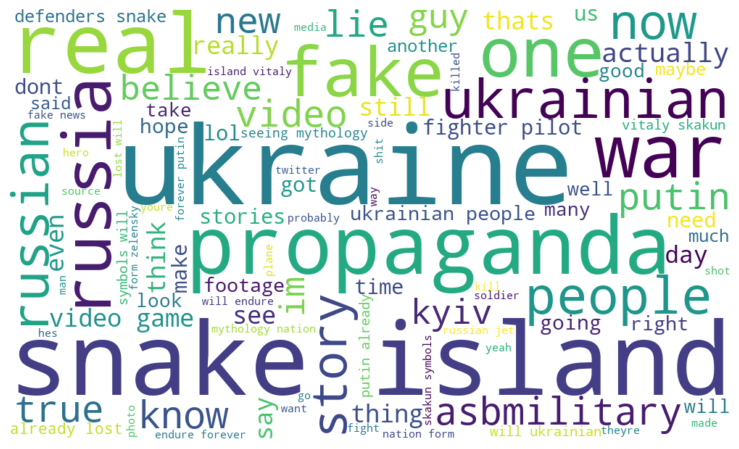

In [ ]:
text=' '.join(df.text_clean.tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
wordcloud.generate(text)
plt.figure(figsize = (32,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Sentiment Analysis of Entire Dataset

#####Initialization of Model

In [ ]:
%%time
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

CPU times: user 12 s, sys: 2.09 s, total: 14.1 s
Wall time: 16 s


In [ ]:
def sentiment_classifier(text,model,tokenizer):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)

    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']

    output = model(input_ids, token_type_ids=token_type_ids,return_dict=True,output_hidden_states=True)
    logits = np.array(output.logits.tolist()[0])
    prob = np.exp(logits)/np.sum(np.exp(logits))
    sentiment = np.sum([(x+1)*prob[x] for x in range(len(prob))])  #use this line if you want the mean score
    
    return sentiment

In [ ]:
%%time
c = 0
Sentiment = []
for index,row in df.iterrows():  #iterate over rows of dataframe
    c+=1
    if c%1000==0:print(f"Tweet {c}/{len(df)}")  #print progres every 1000 rows

    sentiment = sentiment_classifier(row.text,model,tokenizer)  #calculate sentiment and embedding of tweet
    Sentiment.append(sentiment)  #append sentiment of tweet to Sentiment list

df['sentiment'] = Sentiment  #add sentiment column to dataframe of tweets
df.head()

Tweet 1000/17571
Tweet 2000/17571
Tweet 3000/17571
Tweet 4000/17571
Tweet 5000/17571
Tweet 6000/17571
Tweet 7000/17571
Tweet 8000/17571
Tweet 9000/17571
Tweet 10000/17571
Tweet 11000/17571
Tweet 12000/17571
Tweet 13000/17571
Tweet 14000/17571
Tweet 15000/17571
Tweet 16000/17571
Tweet 17000/17571
CPU times: user 44min 53s, sys: 22.9 s, total: 45min 16s
Wall time: 45min 7s


#####Means sentiment of all tweets

In [ ]:
mean_opinion = df['sentiment'].mean()
print(f"Mean opinion of the tweets:{mean_opinion}")

Mean opinion of the tweets:2.595965917982993


#####Sentiment Distribution of entire Dataset

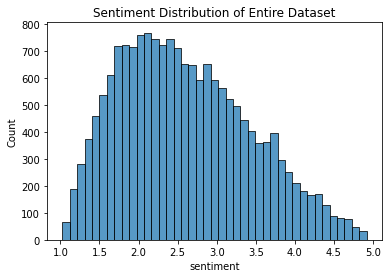

In [ ]:
  df_plot = df
  sns.histplot(data=df_plot, x = "sentiment")
  plt.title(f"Sentiment Distribution of Entire Dataset")
  plt.show()

In [ ]:
df['star']=df.sentiment.round(0)

In [ ]:
df.sample(3)

,screen_name,text,text_clean,sentiment,umap_tfidf_x,umap_tfidf_y,kmeans_label_umap,star
4735,None,"@thehill Are there any legit Media in the ground there or do we have to get all news from one source? I don't support invading any country but these news articles are getting out of hand, from 4000 Russians killed on day 1 to ghost of kiev to 13 killed on an island etc.. show videos",thehill are there any legit media in the ground there or do we have to get all news from one source i dont support invading any country but these news articles are getting out of hand from 4000 russians killed on day 1 to ghost of kiev to 13 killed on an island etc show videos,1.922220,-0.149582,0.358173,2,2.0
11937,None,"@SeanHoover ""Go fcuk yourself Russian warship!""\nThe Ghost of Kiev\n""I need ammunition, not a ride.""\n\nPutin did not realize he had gotten himself involved in an 80s action movie.\n\nAnd everyone knows in all 80s action movies the Russians lose.",seanhoover go fcuk yourself russian warshipthe ghost of kievi need ammunition not a rideputin did not realize he had gotten himself involved in an 80s action movieand everyone knows in all 80s action movies the russians lose,1.840313,-0.261008,0.551919,2,2.0
11085,None,Ghost of Kiev shot down Ghost planes as well 🤣 https://t.co/9w4BzaCApw,ghost of kiev shot down ghost planes as well,2.357163,-0.352886,-0.036256,2,2.0


Retweet count vs Sentiment (couldn't do due to no retweet data in DF.. to get this, would have to redo sentiment model analysis, which would take 45 min..)

In [ ]:
fig = plt.figure(figsize = (8,6))
sns.barplot(data = df, y = 'retweet_count', x = 'star', color = "blue")
plt.xlabel('Sentiment (rounded)', fontsize = 16)
plt.ylabel('Retweet Count', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Retweet vs Sentiment", fontsize = 20)
plt.grid()
#plt.yscale("log")
plt.show()

ValueError: ignored

<Figure size 576x432 with 0 Axes>

##### Top 5 positive and negative tweets

In [ ]:
ndisplay = 5

print(f"Top {ndisplay} Most Positive Tweets")
df_display = df.sort_values(by = ['sentiment'], ascending = False)
c=0
for index,row in df_display.iterrows():
    c+=1
    text = codecs.decode(row.text, 'unicode_escape')
    print(f"\tsentiment = {row.sentiment:.2f}: {text}")
    if c>=ndisplay:break

Top 5 Most Positive Tweets
	sentiment = 4.92: There is a fantastic documentary about the #ghostofkiev called "The Greatest Story Never Told". It's on Odysee, I believe. Highly recommended!
	sentiment = 4.91: @Ghost_of_Kiev perfect absolutely perfect
	sentiment = 4.90: Best nickname of all time. #ghostofkiev https://t.co/1Ky7thV3eI
	sentiment = 4.89: One of my heroes. These days we have a lot of them! The ghost of Kiev, a man who saved many innocent Ukrainians in this Russian aggression
#Ukraine #ghostofkiev https://t.co/z2KOO4GK0c
	sentiment = 4.89: One of my heroes. These days we have a lot of them! The ghost of Kiev, a man who saved many innocent Ukrainians in this Russian aggression
#Ukraine #ghostofkiev https://t.co/z2KOO4GK0c


In [ ]:
ndisplay = 5

print(f"Top {ndisplay} Most Negative Tweets")
df_display = df.sort_values(by = ['sentiment'], ascending = True)
c=0
for index,row in df_display.iterrows():
    c+=1
    text = codecs.decode(row.text, 'unicode_escape')
    print(f"\tsentiment = {row.sentiment:.2f}: {text}")
    if c>=ndisplay:break

Top 5 Most Negative Tweets
	sentiment = 1.02: Absolute crap. What sort of nonsense is this? ð¤£ Which "Fighter  Jets" are EU countries going to provide? Who will fly them? Ghost of Kiev? Verified handles are spreading propaganda &amp; information warfare. ð @MacaesBruno @IAPonomarenko @apmassaro3  #RussiaUkraineConflict https://t.co/kSSPJ8QPlb
	sentiment = 1.03: @baileylinny4 @PodcastZed This is possibly the dumbest shit Iâve ever seen. The mental gymnastics are unreal. Iâll take the Ghost of Kiev any day over this garbage.
	sentiment = 1.03: @Ghost_of_Kiev This is absolutely horrific, fuck! horrible Loss of life ð i  hope this shit would end
	sentiment = 1.05: @Ghost_of_Kiev All this death on behalf of one manâs ego. Disgusting
	sentiment = 1.05: @Ghost_of_Kiev Absolutly teribble and sad... this is a crime


#Clustering Tweets

#####IFIDF Clustering

In [ ]:
#TFIDF  
tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words = 'english')
tfidf_embedding = tfidf_vectorizer.fit_transform(df.text_clean) #takes text documents and converts to a TF/TFIDF embedding
#Fit each tweet to a vector 
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

nvocab = len(tfidf_feature_names)
ntweets = len(df.text_clean)
print(f"{ntweets} tweets, {nvocab} words in vocabulary")

17571 tweets, 4132 words in vocabulary


#####Umap TfIDF Clustering

In [ ]:
%%time
#UMAP Embedding
umap_tfidf_embedding = umap.UMAP(n_components = 2, metric = 'hellinger').fit_transform(tfidf_embedding)

#using Z-score -> python package stats 
umap_tfidf_embedding = stats.zscore(umap_tfidf_embedding, nan_policy = 'omit')

#Add UMAP Embeddings to DataFrame
df['umap_tfidf_x'] = umap_tfidf_embedding[:,0]
df['umap_tfidf_y'] = umap_tfidf_embedding[:,1]


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
/usr/l

CPU times: user 1min 28s, sys: 1.03 s, total: 1min 29s
Wall time: 1min 4s


#####K-Means Clustering (3 clusters)

In [ ]:
n_umap_clusters = 3

kmeans_label_umap = cluster.KMeans(n_clusters=n_umap_clusters).fit_predict(tfidf_embedding)
df['kmeans_label_umap'] = [str(x) for x in kmeans_label_umap]

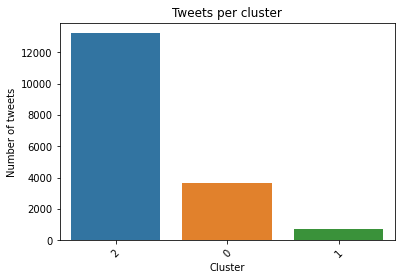

In [ ]:
    sns.countplot(data=df, x = "kmeans_label_umap")
    plt.title(f"Tweets per cluster")
    plt.xticks(rotation=45)
    plt.ylabel("Number of tweets")
    plt.xlabel("Cluster")
    plt.show()

#####Sentiment for each Cluster

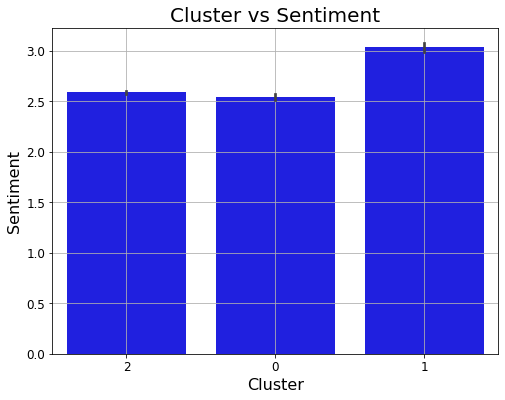

In [ ]:
fig = plt.figure(figsize = (8,6))
sns.barplot(data = df, y = 'star', x = 'kmeans_label_umap', color = "blue")
plt.xlabel('Cluster', fontsize = 16)
plt.ylabel('Sentiment', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Cluster vs Sentiment", fontsize = 20)
plt.grid()
#plt.yscale("log")
plt.show()

#####Wordcloud for each cluster

In [ ]:
def kmeans_wordcloud_userhist(df, cluster_label_column,stopwords):
    print(cluster_label_column)
    for k in np.sort(df[cluster_label_column].unique()):
        s=df[df[cluster_label_column]==k]
        text=' '.join(s.text_clean.tolist()).lower()
        wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
        wordcloud.generate(text)

        print(f"\n\tCluster {k} has {len(s)} tweets")
        plt.figure(figsize = (16,4))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    return 1

In [ ]:
stopwords = set(STOPWORDS)
stopwords.add("Ghost")
stopwords.add("Kiev")
stopwords.add("Ghostofkiev")

kmeans_label_umap

	Cluster 0 has 3633 tweets


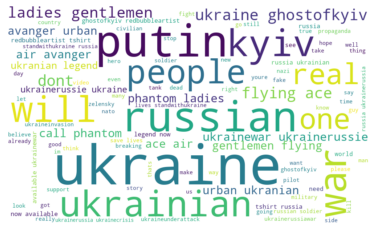


	Cluster 1 has 712 tweets


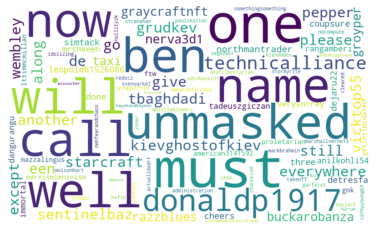


	Cluster 2 has 13226 tweets


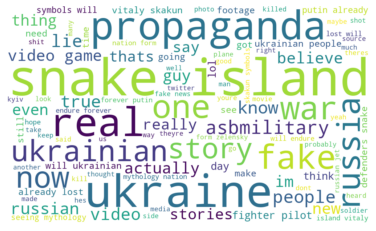

1

In [ ]:


cluster_label_column= 'kmeans_label_umap'
kmeans_wordcloud_userhist(df,cluster_label_column,stopwords )

In [ ]:
!jupyter nbconvert --to HTML FinalProject.ipynb

[NbConvertApp] Converting notebook FinalProject.ipynb to HTML
[NbConvertApp] Writing 2095350 bytes to FinalProject.html
